<a href="https://colab.research.google.com/github/MarriumJilani/Comparative-Analysis-of-Human-Pose-Estimation-Models-for-Yoga-Poses/blob/main/MoveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move the uploaded file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Replace 'dataset-url' with the actual URL of the dataset
!kaggle datasets download -d niharika41298/yoga-poses-dataset



 98% 281M/288M [00:03<00:00, 114MB/s]
100% 288M/288M [00:03<00:00, 97.3MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip -q /content/yoga-poses-dataset.zip -d dataset

In [ ]:
!ls
!ls /content/dataset
!ls /content/dataset/DATASET
!ls /content/dataset/DATASET/TEST
!ls /content/dataset/DATASET/TRAIN

dataset  sample_data  yoga-poses-dataset.zip
DATASET
TEST  TRAIN
downdog  goddess  plank  tree  warrior2
downdog  goddess  plank  tree  warrior2


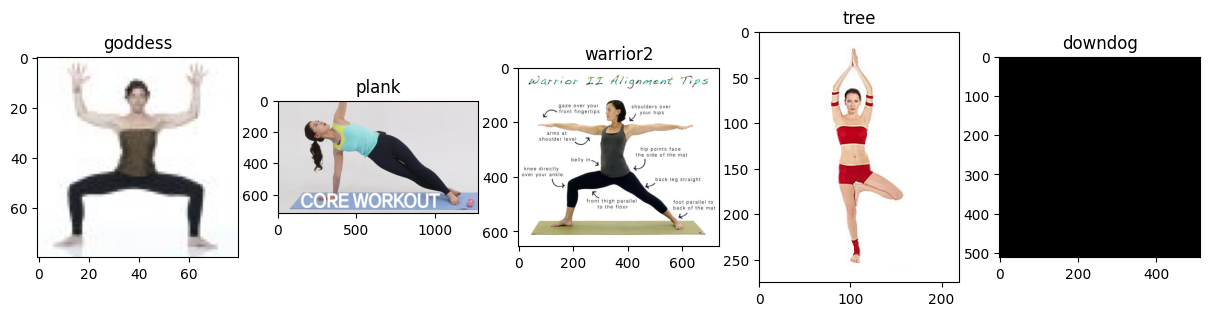

In [ ]:
import os
# Load the dataset
data_path = '/content/dataset/DATASET'
train_path = os.path.join(data_path, 'TRAIN')
test_path = os.path.join(data_path, 'TEST')

# Use the OS library to list classes in the dataset
classes = os.listdir(train_path)

# Visualize one sample for each class
import matplotlib.pyplot as plt
import cv2

# Display one sample image for each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_label in enumerate(classes):
    class_path = os.path.join(train_path, class_label)
    sample_image = os.path.join(class_path, os.listdir(class_path)[0])
    image = cv2.imread(sample_image)
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(class_label)

plt.show()




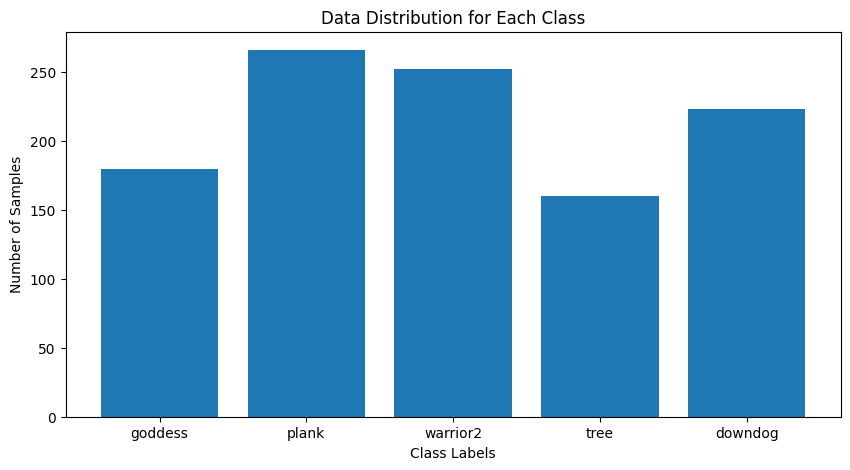

In [ ]:
# Graphical data distribution for each class using a bar chart
class_counts = {class_label: len(os.listdir(os.path.join(train_path, class_label))) for class_label in classes}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Data Distribution for Each Class")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.show()

# Check for class imbalances
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
class_imbalance_threshold = 0.8

if max_samples / min_samples > class_imbalance_threshold:
    print("Warning: There might be class imbalance.")
else:
    print("No significant class imbalance observed.")

In [ ]:
import cv2

# Load an example image from your dataset
example_image_path = "/content/dataset/DATASET/TEST/plank/00000000.jpg"
example_image = cv2.imread(example_image_path)

# Get the image dimensions
img_height, img_width, _ = example_image.shape

print("Image Height:", img_height)
print("Image Width:", img_width)


Image Height: 1080
Image Width: 1920


## **MoveNet**

In [ ]:
WIDTH = HEIGHT = 256

In [ ]:

# Load the MoveNet model
import tensorflow as tf
import tensorflow_hub as hub

# Load the MoveNet model
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures["serving_default"]


In [ ]:
# Function to perform MoveNet inference on an image with variable size
def run_movenet_inference_variable_size(image):
    # Get the original image dimensions
    original_height, original_width, _ = image.shape

    # Resize the image to the target shape and cast to an int32 vector
    input_image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
    # Create a batch (input tensor)
    input_image = tf.expand_dims(input_image, axis=0)

    # Perform inference
    results = movenet(input_image)

    # Reshape the results for convenience
    keypoints = results["output_0"].numpy()[:,:,:51].reshape((6, 17, 3))

    return keypoints, (original_height, original_width)


In [ ]:
cyan = (255, 255, 0)
magenta = (255, 0, 255)
EDGE_COLORS = {
    (0, 1): magenta,
    (0, 2): cyan,
    (1, 3): magenta,
    (2, 4): cyan,
    (0, 5): magenta,
    (0, 6): cyan,
    (5, 7): magenta,
    (7, 9): cyan,
    (6, 8): magenta,
    (8, 10): cyan,
    (5, 6): magenta,
    (5, 11): cyan,
    (6, 12): magenta,
    (11, 12): cyan,
    (11, 13): magenta,
    (13, 15): cyan,
    (12, 14): magenta,
    (14, 16): cyan
}

In [ ]:
import numpy as np

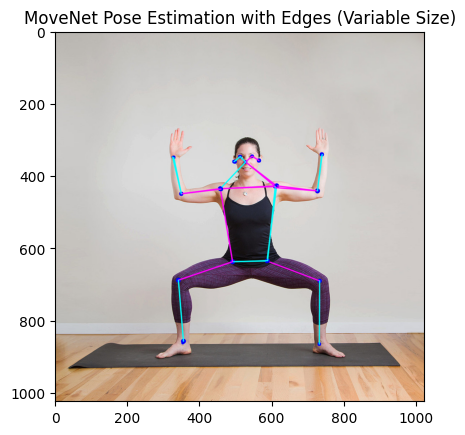

In [ ]:

# Function to draw MoveNet keypoints and edges on a frame with variable size
def draw_movenet_keypoints_and_edges_variable_size(frame, keypoints, original_dimensions, threshold=0.11):
    # Get original dimensions
    original_height, original_width = original_dimensions

    # Iterate through instances
    for instance_keypoints in keypoints:
        # Denormalize coordinates based on original image dimensions
        denormalized_coordinates = np.multiply(instance_keypoints[:, :3], [original_width, original_height, 1])

        # Draw keypoints
        for keypoint in denormalized_coordinates:
            keypoint_y, keypoint_x, keypoint_confidence = keypoint
            if keypoint_confidence > threshold:
                # Adjust the radius for better visibility
                radius = int(8 * keypoint_confidence)
                cv2.circle(
                    img=frame,
                    center=(int(keypoint_x), int(keypoint_y)),
                    radius=radius,
                    color=(255, 0, 0),
                    thickness=-1
                )

        # Draw edges
        for edge, color in EDGE_COLORS.items():
            p1, p2 = edge
            if p1 < len(denormalized_coordinates) and p2 < len(denormalized_coordinates):
                y1, x1, confidence_1 = denormalized_coordinates[p1]
                y2, x2, confidence_2 = denormalized_coordinates[p2]
                # Draw the line from point 1 to point 2 if the confidence > threshold
                if (confidence_1 > threshold) and (confidence_2 > threshold):
                    cv2.line(
                        img=frame,
                        pt1=(int(x1), int(y1)),
                        pt2=(int(x2), int(y2)),
                        color=color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )

# Example usage on an image from the dataset
example_image_path = "/content/dataset/DATASET/TEST/goddess/00000000.jpg"
example_image = cv2.imread(example_image_path)

# Perform MoveNet inference on the example image with variable size
keypoints, original_dimensions = run_movenet_inference_variable_size(example_image)


# Draw MoveNet keypoints and edges on the example image with variable size
draw_movenet_keypoints_and_edges_variable_size(example_image, keypoints, original_dimensions, threshold=0.11)

# Display the result
plt.imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
plt.title("MoveNet Pose Estimation with Edges (Variable Size)")
plt.show()

(1024, 1024, 3)


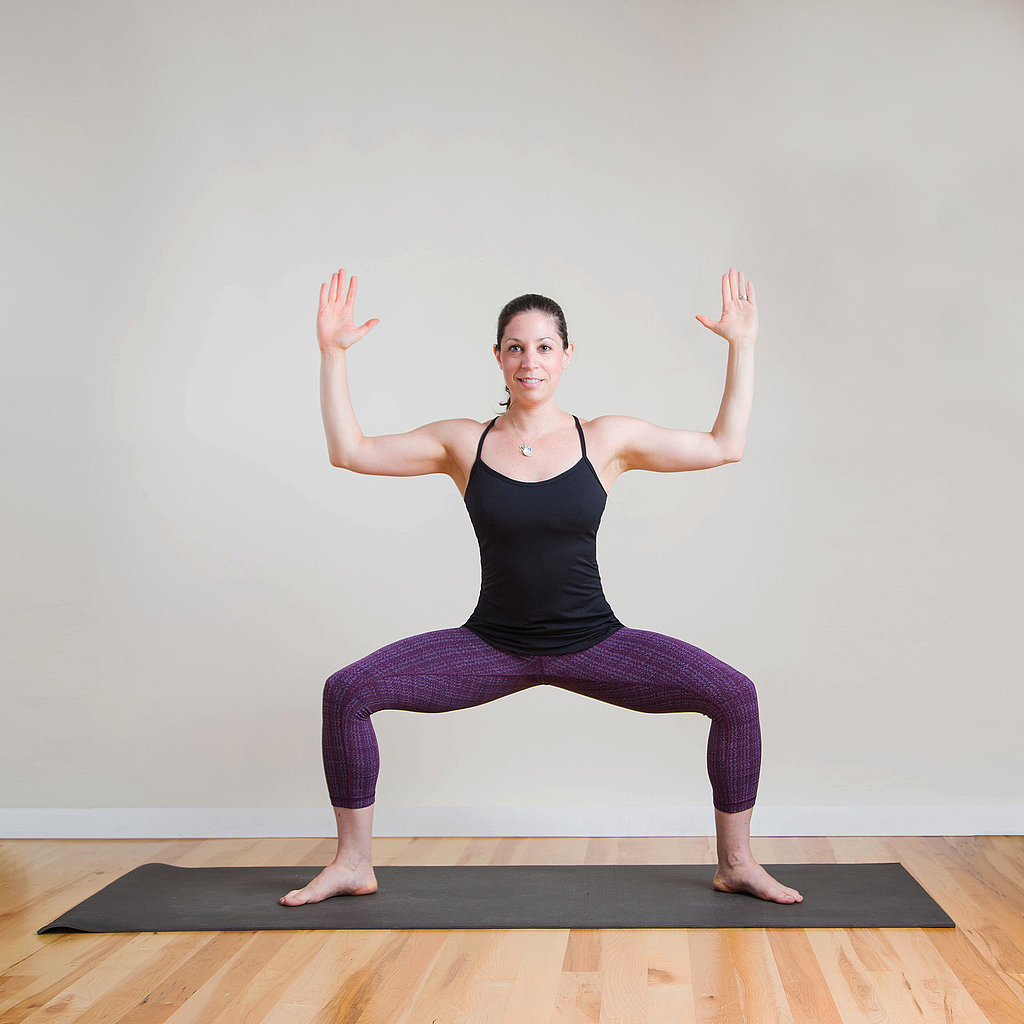

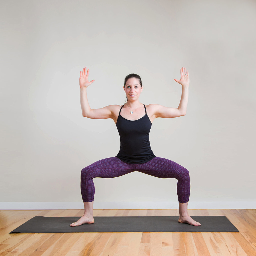

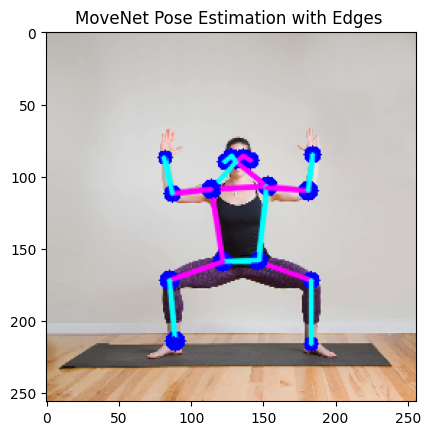

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def resize_and_pad(image, target_size=(256, 256)):
    # Ensure the image has 3 channels (remove alpha channel if present)
    if image.shape[2] > 3:
        image = image[:, :, :3]

    # Resize while maintaining the original aspect ratio
    aspect_ratio = image.shape[1] / image.shape[0]
    new_width = int(target_size[1])
    new_height = int(target_size[1] / aspect_ratio)

    resized = cv2.resize(image, (new_width, new_height))

    # Calculate padding values
    pad_top = max((target_size[0] - new_height) // 2, 0)
    pad_bottom = max(target_size[0] - new_height - pad_top, 0)
    pad_left = max((target_size[1] - new_width) // 2, 0)
    pad_right = max(target_size[1] - new_width - pad_left, 0)

    # Pad the image
    padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

    return padded


input_gif = cv2.imread("/content/dataset/DATASET/TEST/goddess/00000000.jpg")
print(input_gif.shape)
# Resize and pad the image
resized_image = resize_and_pad(input_gif, target_size=(256, 256))

# Display the original and resized images for comparison
cv2_imshow( input_gif)

cv2_imshow(resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Perform MoveNet inference on the example image with variable size
keypoints, original_dimensions = run_movenet_inference_variable_size(resized_image)

# Draw MoveNet keypoints and edges on the example image with variable size
draw_movenet_keypoints_and_edges_variable_size(resized_image, keypoints, original_dimensions, threshold=0.11)

# Display the result
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title("MoveNet Pose Estimation with Edges ")
plt.show()


In [ ]:
# Assuming you have a list of class labels
classes = ['downdog', 'goddess', 'tree', 'plank', 'warrior2']

# Initialize lists to store MoveNet features and corresponding labels
movenet_features = []
labels = []

# Loop through each class
for class_label in classes:
    train_path_class = os.path.join(train_path, class_label)
    test_path_class = os.path.join(test_path, class_label)

    # Get the list of image paths in the TRAIN folder for the current class
    train_image_paths = [os.path.join(train_path_class, img) for img in os.listdir(train_path_class)]

    # Loop through each image in the TRAIN folder for the current class
    for image_path in train_image_paths:
      # Load your input_gif (assuming it's a single frame for simplicity)

        # Load and resize the image
        image = cv2.imread(image_path)
        print(image_path,image.shape)
        resized_image = resize_and_pad(image, target_size=(256, 256))

        # Perform MoveNet inference on the resized image
        keypoints, original_dimensions = run_movenet_inference_variable_size(resized_image)

        # Process and extract features (adjust this based on your specific needs)
        flat_keypoints = keypoints.flatten()

        # Append the features and corresponding label to the lists
        movenet_features.append(flat_keypoints)
        labels.append(class_label)

    # Get the list of image paths in the TEST folder for the current class
    test_image_paths = [os.path.join(test_path_class, img) for img in os.listdir(test_path_class)]

    # Loop through each image in the TEST folder for the current class
    for image_path in test_image_paths:
        # Load and resize the image
        image = cv2.imread(image_path)
        resized_image = resize_and_pad(image, target_size=(256, 256))

        # Perform MoveNet inference on the resized image
        keypoints, original_dimensions = run_movenet_inference_variable_size(resized_image)

        # Process and extract features (adjust this based on your specific needs)
        flat_keypoints = keypoints.flatten()

        # Append the features and corresponding label to the lists
        movenet_features.append(flat_keypoints)
        labels.append(class_label)

# Convert lists to numpy arrays
movenet_features = np.array(movenet_features)
labels = np.array(labels)

# Now, movenet_features contains MoveNet features for all images in your dataset
# labels contains corresponding labels


/content/dataset/DATASET/TRAIN/downdog/00000188.png (512, 512, 3)
/content/dataset/DATASET/TRAIN/downdog/00000348.jpg (1300, 957, 3)
/content/dataset/DATASET/TRAIN/downdog/00000301.jpg (350, 750, 3)
/content/dataset/DATASET/TRAIN/downdog/00000244.jpg (349, 620, 3)
/content/dataset/DATASET/TRAIN/downdog/00000409.jpg (400, 600, 3)
/content/dataset/DATASET/TRAIN/downdog/00000240.jpg (439, 643, 3)
/content/dataset/DATASET/TRAIN/downdog/00000287.png (345, 700, 3)
/content/dataset/DATASET/TRAIN/downdog/00000365.jpg (577, 740, 3)
/content/dataset/DATASET/TRAIN/downdog/00000343.jpg (349, 620, 3)
/content/dataset/DATASET/TRAIN/downdog/00000392.jpg (614, 614, 3)
/content/dataset/DATASET/TRAIN/downdog/00000132.png (706, 1499, 3)
/content/dataset/DATASET/TRAIN/downdog/00000333.jpg (766, 740, 3)
/content/dataset/DATASET/TRAIN/downdog/00000272.jpg (546, 850, 3)
/content/dataset/DATASET/TRAIN/downdog/00000170.jpg (415, 865, 3)
/content/dataset/DATASET/TRAIN/downdog/00000355.jpg (1920, 2560, 3)
/conte

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movenet_features, labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9003215434083601


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],

}

# Initialize the model
model = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3)

# Fit the model with the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")


Best Model Accuracy: 0.8810289389067524


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Confusion Matrix:
[[56  0  5  0  0]
 [ 1 38  5  2 12]
 [ 1  1 77  0  2]
 [ 0  0  0 47  2]
 [ 0  3  2  1 56]]
Classification Report:
              precision    recall  f1-score   support

     downdog       0.97      0.92      0.94        61
     goddess       0.90      0.66      0.76        58
       plank       0.87      0.95      0.91        81
        tree       0.94      0.96      0.95        49
    warrior2       0.78      0.90      0.84        62

    accuracy                           0.88       311
   macro avg       0.89      0.88      0.88       311
weighted avg       0.89      0.88      0.88       311

